In [93]:
# @hidden_cell
# The project token is an authorization token that is used to access project resources like data sources, connections, and used by platform APIs.
from project_lib import Project
project = Project(spark.sparkContext, '303865e9-7b13-4363-ba64-13861ceab22f', 'p-a99fa9f98d957c12af7799c24a12d890c80ad681')
pc = project.project_context

# Build and Deploy a Fraud Detection Model in Jupyternotebook

In this notebook, we will be working with some auto insurance data ([Download here]()) and create a predictive model that predicts if an insurance claim is fraudulent or not. This is a Binary Classification task, and we will be creating a Random Forest model using Pyspark.

You will learn to:
    
1. ingest/export data from/to Object Storage in Watson Studio,
2. perform exploratory data analysis(EDA) on the insurance data by drawing some visualizations,
3. preprocess data,
4. create a Random Forest Model using PySpark,
6. Deploy model to Watson Machine Learning.

Note: this analysis is similified to walk you through steps it takes to build and deploy a ML model. You can perform more transformations and analysis on the data once you get the hang of it.

## Table of Content

1. Import packages
2. Load Insurance data from Object Storage
3. Review Data
4. Data Preparation
5. Exploratory Data Analysis
        5.1 How many fraudulent cases are there in the dataset?
        4.2 5.2 Which incident_severity level has highest fraud ratio?
6. Modeling
7. Save output back to Object Storage
8. Deploy Model to Watson Machine Learning
        

Task list:

    Task 1: Run the cell to import all the packages
    Task 2: Upload sample data to Object Storage and Insert to code
    Task 3: Check summary statistics of df_data_1
    Task 4: Run the cell bellow to check unqiue values for categorical columns.
    Task 5: Run the cell bellow to change "?" to "UNKNOWN" for the police_report_available column.
    Task 6: Run the cell bellow to draw a bar chart of fraud_reported.
    Task 7: Run the cell bellow to draw a mosaic plot for fraud_reported by incident_severity level.
    Task 8: Run the cell bellow to build the model. The comment will help you understand what each step is doing.
    Task 9: Follow the steps bellow and save output file to Object Storage.
    Task 10: Follow the steps bellow to save model to Watson Machine Learning.

## 1. Import packages

Python packages contain modules, which are simply Python source files that can expose classes, functions and global variables. Users need to import those packages/modules first before you can use those functions in the current environment.

**Task 1: Run the cell to import all the packages**


<div class="panel-group" id="accordion-13">
  <div class="panel panel-default">
    <div class="panel-heading">
      <h4 class="panel-title">
        <a data-toggle="collapse" data-parent="#accordion-13" href="#collapse1-13">
        Hint for running the cell below</a>
      </h4>
    </div>
    <div id="collapse1-13" class="panel-collapse collapse">
      <div class="panel-body"> 
      1. Select the cell below, and press Shift + Return; OR<br>
      2. Select the cell below, and click "Cell" tab in the menu bar => Run Cells.
  </div>

In [4]:
# for visulization
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.mosaicplot import mosaic

# for modeling
from pyspark.sql import SQLContext,SparkSession
from pyspark.sql.types import StringType, DoubleType, FloatType, IntegerType
from pyspark.sql.functions import udf, length,col
from pyspark.ml import Pipeline
from pyspark.ml.feature import OneHotEncoderEstimator, StringIndexer, VectorAssembler, IndexToString
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator

# for model deployment
from watson_machine_learning_client import WatsonMachineLearningAPIClient
from repository.mlrepositoryclient import MLRepositoryClient
from repository.mlrepositoryartifact import MLRepositoryArtifact
from repository.mlrepository import MetaProps

## 2. Load Insurance data from Object Storage(default data repository for Watson Studio)

Watson Studio supports multiple data sources. See a complete list of supported data sources and connectors [here](https://dataplatform.cloud.ibm.com/docs/content/wsj/manage-data/conn_types.html).

**Task 2: Upload sample data to Object Storage and Insert to code**


<form> 
<input type="checkbox"><label>1. Click 1001 botton on the upper right corner, click Files => browse => locate "insurance_claims.csv" you just downloaded to upload it to Object Storage </label> <br>
<input type="checkbox"><label>2. Once it has been uploaded, select the empty cell bellow then click on "Insert to code" under insurance_claims.csv => choose "Insert Pandas DataFrame" => Run the Cell </label> <br>

</form>

In [9]:
import types
import pandas as pd
from botocore.client import Config
import ibm_boto3

def __iter__(self): return 0

# @hidden_cell
# The following code accesses a file in your IBM Cloud Object Storage. It includes your credentials.
# You might want to remove those credentials before you share the notebook.
client_49b905d066984c87befa74cd984824cd = ibm_boto3.client(service_name='s3',
    ibm_api_key_id='Mw1XukXfO3046spa1LOjC3M60Pluh9_TZXROKViCeP-H',
    ibm_auth_endpoint="https://iam.ng.bluemix.net/oidc/token",
    config=Config(signature_version='oauth'),
    endpoint_url='https://s3-api.us-geo.objectstorage.service.networklayer.com')

body = client_49b905d066984c87befa74cd984824cd.get_object(Bucket='watsonstudioworkshop-donotdelete-pr-ac3u5x4g9czkny',Key='insurance_claims_v2.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

df_data_1 = pd.read_csv(body)
df_data_1.head()

df_data_1 = df_data_1[["months_as_customer", "age", "incident_severity", "insured_hobbies", "police_report_available", "capital-loss", "vehicle_claim", "auto_year",  "fraud_reported", "policy_annual_premium", "authorities_contacted"]]

## 3. Review Data

Let's take a quick look at the data by checking summary statistics and unique values of the categorical columns and see if there is any data preparation steps need to be applied to the data.

**Task 3: Check summary statistics of df_data_1**

<div class="panel-group" id="accordion-4">
  <div class="panel panel-default">
    <div class="panel-heading">
      <h4 class="panel-title">
        <a data-toggle="collapse" data-parent="#accordion-4" href="#collapse1-4">
        Hints</a>
      </h4>
    </div>
    <div id="collapse1-4" class="panel-collapse collapse">
      <div class="panel-body"> 
      copy and paste the following code to the cell below, and run the cell: <br>
    
      df_data_1.describe()

  </div>

In [10]:
df_data_1.describe()

months_as_customer          age   capital-loss  vehicle_claim  \
count         1000.000000  1000.000000    1000.000000    1000.000000   
mean           203.954000    38.948000  -26793.700000   37928.950000   
std            115.113174     9.140287   28104.096686   18886.252893   
min              0.000000    19.000000 -111100.000000      70.000000   
25%            115.750000    32.000000  -51500.000000   30292.500000   
50%            199.500000    38.000000  -23250.000000   42100.000000   
75%            276.250000    44.000000       0.000000   50822.500000   
max            479.000000    64.000000       0.000000   79560.000000   

         auto_year  policy_annual_premium  
count  1000.000000            1000.000000  
mean   2005.103000            1256.406150  
std       6.015861             244.167395  
min    1995.000000             433.330000  
25%    2000.000000            1089.607500  
50%    2005.000000            1257.200000  
75%    2010.000000            1415.695000  
max    2015.000000            2047.590000

**Task 4: Run the cell bellow to check unqiue values for categorical columns.**

In [14]:
for i in ["incident_severity", "insured_hobbies", "police_report_available", "fraud_reported", "auto_year"]:
    print(i + ":")
    print(df_data_1[i].unique())
    print("\n")

incident_severity:
['Major Damage' 'Minor Damage' 'Total Loss' 'Trivial Damage']


insured_hobbies:
['sleeping' 'reading' 'board-games' 'bungie-jumping' 'base-jumping' 'golf'
 'camping' 'dancing' 'skydiving' 'movies' 'hiking' 'yachting' 'paintball'
 'chess' 'kayaking' 'polo' 'basketball' 'video-games' 'cross-fit'
 'exercise']


police_report_available:
['YES' '?' 'NO']


fraud_reported:
['Y' 'N']


auto_year:
[2004 2007 2014 2009 2003 2012 2015 1996 2002 2006 2000 2010 1999 2011
 2005 2008 1995 2001 1998 1997 2013]




## 4. Data Preparation

**After review this output, we have a better understanding of what our data looks like. And for data preparation, we may want to change the cateogory "?"  in _police_report_available_ to "UNKNOWN" to make it more readable.** 

**Task 5: Run the cell bellow to change "?" to "UNKNOWN" for the _police_report_available_ column.**

In [15]:
df_data_1['police_report_available'] = df_data_1['police_report_available'].apply(lambda x :'UNKNOWN' if x == "?" else x)

## 5. Exploratory Data Analysis(EDA)

In this section, we will further explore the data by drawing some visualizations. Here are some sample questions we want to answer through EDA:

1. How many fraudulent cases do we have in the dataset?
2. Which incident_severity level has highest fraud ratio?

### 5.1 How many fraudulent cases are there in the dataset?
**Task 6: Run the cell bellow to draw a bar chart of fraud_reported**.

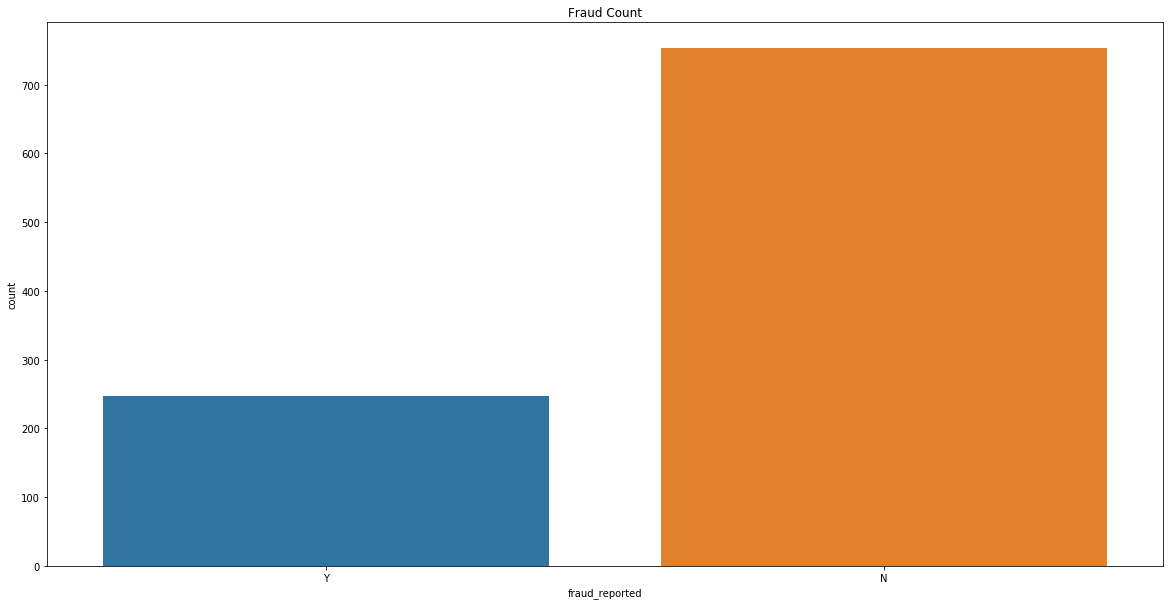

In [21]:
f, ax = plt.subplots(figsize=(20, 10))
sns.countplot('fraud_reported',data=df_data_1)
plt.title("Fraud Count")
plt.show()

Like most fraud datasets, our label distribution is skewed, aka. more non-fraudulent cases than fraudulent cases.

### 5.2 Which incident_severity level has highest fraud ratio?
**Task 7: Run the cell bellow to draw a mosaic plot for fraud_reported by incident_severity level**.

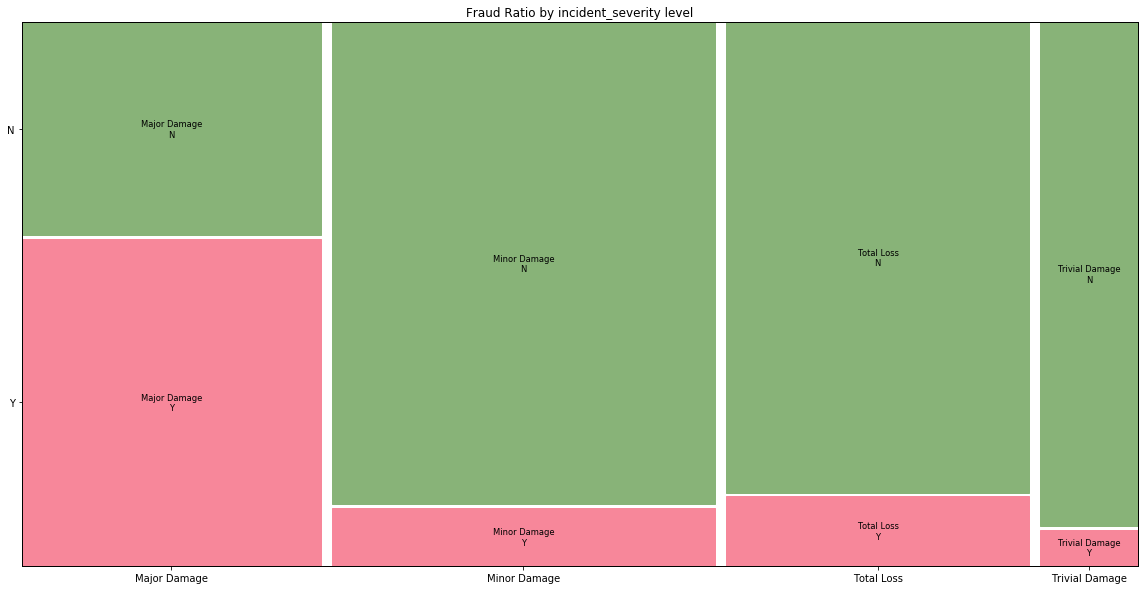

In [78]:
props = {}
props[('Major Damage', 'Y')] = {'color': 'xkcd:rose pink'}
props[('Major Damage', 'N')] = {'color': 'xkcd:sage green'}

props[('Minor Damage', 'Y')] = {'color': 'xkcd:rose pink'}
props[('Minor Damage', 'N')] = {'color': 'xkcd:sage green'}

props[('Total Loss', 'Y')] = {'color': 'xkcd:rose pink'}
props[('Total Loss', 'N')] = {'color': 'xkcd:sage green'}

props[('Trivial Damage', 'Y')] = {'color': 'xkcd:rose pink'}
props[('Trivial Damage', 'N')] = {'color': 'xkcd:sage green'}

with mpl.rc_context():
    mpl.rc("figure", figsize=(20,10))
    mosaic(df_data_1,["incident_severity", "fraud_reported"], gap=0.01, properties=props, title = "Fraud Ratio by incident_severity level")
    plt.show()

It seems when sverity level = Major Damage, the fraud ratio is the highest.

## 6. Modeling

In this section we will starting building the random forest model to predict fraud.

**Task 8: Run the cell bellow to build the model. The comment will help you understand what each step is doing.**

In [86]:
label = "fraud_reported"
catCols = ["incident_severity", "insured_hobbies", "police_report_available", "auto_year"]
numCols = ["months_as_customer", "age", "capital-loss", "vehicle_claim", "policy_annual_premium"]

# convert pandas dataframe to spark dataframe
spark_df = spark.createDataFrame(df_data_1)

print("\n*********" + "Split data into training and test sets" + "*********")

# split into training and test sets
trainingData, testData = spark_df.randomSplit([0.7, 0.3], seed = 824)
trainingData.cache()
testData.cache()
print("Sample Size: " + str(spark_df.count()))
print("Training set size: " + str(trainingData.count()))
print("Testing set size: " + str(testData.count()))
print("Distribution of target in trainingData is: \n ", trainingData.groupBy("fraud_reported").count().take(2))

print("\n*********" + "Building pipeline" + "*********")

stages = [] # stages in our Pipeline
for categoricalCol in catCols:
    # Category Indexing with StringIndexer
    stringIndexer = StringIndexer(inputCol=categoricalCol, outputCol=categoricalCol + "Index")
    # Use OneHotEncoder to convert categorical variables into binary SparseVectors
    encoder = OneHotEncoderEstimator(inputCols=[stringIndexer.getOutputCol()], outputCols=[categoricalCol + "classVec"])
    # Add stages.  These are not run here, but will run all at once later on.
    stages += [stringIndexer, encoder]

# encode label   
label_stringIdx = StringIndexer(inputCol="fraud_reported", outputCol="label")
stages += [label_stringIdx]

# assemble feature vector
assemblerInputs = [c + "classVec" for c in catCols] + numCols
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")
stages += [assembler]

# add RandomForestClassifier to the pipeline
rf_model = RandomForestClassifier(labelCol="label", featuresCol="features")
stages += [rf_model]

# convert predicted label to string
labelConverter = IndexToString(inputCol="prediction", outputCol="predictedLabel", labels=['N', 'Y'])
stages += [labelConverter]

# construct pipeline
pipeline_build = Pipeline().setStages(stages)

print("\n*********" + "Model Training" + "*********")

# fit model 
model_fit = pipeline_build.fit(trainingData)


print("\n*********" + "Model Evaluation" + "*********")

predictions = model_fit.transform(testData)

evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction", labelCol="label")

# Model Eval: Area under ROC vs. precision-recall curve
tp = predictions[(predictions.label==1) & (predictions.prediction == 1)].count()
tn = predictions[(predictions.label == 0) & (predictions.prediction==0)].count()
fp = predictions[(predictions.label == 0) & (predictions.prediction==1)].count()
fn = predictions[(predictions.label == 1) & (predictions.prediction == 0)].count()
r = float(tp)/(tp + fn)
p = float(tp) / (tp + fp)

print("True Positives:", tp)
print("True Negatives:", tn)
print("False Positives:", fp)
print("False Negatives:", fn)
print("Total:", predictions.count())
print("recall:", r)
print("precision:", p)
print("Accuracy:", (tp + tn)/predictions.count())
print('Done! areaUnderROC = {:.2f}.'.format(evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"}))) 
print('Done! areaUnderPR = {:.2f}.'.format(evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderPR"})))


*********Split data into training and test sets*********
Sample Size: 1000
Training set size: 718
Testing set size: 282
Distribution of target in trainingData is: 
  [Row(fraud_reported='Y', count=187), Row(fraud_reported='N', count=531)]

*********Building pipeline*********

*********Model Training*********

*********Model Evaluation*********
True Positives: 34
True Negatives: 198
False Positives: 24
False Negatives: 26
Total: 282
recall: 0.5666666666666667
precision: 0.5862068965517241
Accuracy: 0.8226950354609929
Done! areaUnderROC = 0.84.
Done! areaUnderPR = 0.55.


## 7. Save output back to Object Storage

**Task 9: Follow the steps bellow and save output file to Object Storage.**

9.1 Click on the triple dot on the top right corner, click **Insert project token**, it will insert a cell at the top of the notebook containing the project token. Run that cell.

9.2 Run the cell bellow to save the prediction file to Object Storage.

In [ ]:
pred_pd = predictions.toPandas()
project.save_data("pred_output.csv", pred_pd.to_csv(index = False))

Now you should see the **pred_output.csv** under the **Data Assets** tab in the project view.

## 8. Deploy Model to Watson Machine Learning

**Task 10: Follow the steps bellow to save model to Watson Machine Learning.**

10.1 Grab your WML credentials from IBM Cloud and copy and paste it in the cell below. 
10.2 Then run the cell.

In [95]:
wml_credentials = {
  "apikey": "6Y4qLNIhiVP5kH1-vsLjW4W9uNLoQNR3S2S9QUhq5VyL",
  "iam_apikey_description": "Auto-generated for key e56ed203-7777-4b8c-8b28-539fe06ac7ab",
  "iam_apikey_name": "Service credentials-1",
  "iam_role_crn": "crn:v1:bluemix:public:iam::::serviceRole:Writer",
  "iam_serviceid_crn": "crn:v1:bluemix:public:iam-identity::a/16d2f14dfb22f4e0b327a564b2b17408::serviceid:ServiceId-cf3549aa-4b97-4b93-a4fc-a20f71ec1750",
  "instance_id": "6f4bc70b-0857-4187-9b4b-bf6e8d91ae18",
  "url": "https://us-south.ml.cloud.ibm.com"
}

client = WatsonMachineLearningAPIClient(wml_credentials)

# configure model metadata
model_props = {
    client.repository.ModelMetaNames.NAME: "Insurance_Fraud_Detection",
    #client.repository.ModelMetaNames.TRAINING_DATA_REFERENCE: training_data_reference,
    client.repository.ModelMetaNames.EVALUATION_METHOD: "binary",
    client.repository.ModelMetaNames.EVALUATION_METRICS: [
        {
           "name": "areaUnderROC",
           "value": .6,
           "threshold": 0.5
        }
    ]
}

published_model_details = client.repository.store_model(model=model_fit, meta_props=model_props, training_data=trainingData, pipeline=pipeline_build)
model_uid = client.repository.get_model_uid(published_model_details)

If you did not see any error message till this point, you should see the **Insurance_Fraud_Detection** model under the Models tab in the project view. Now go back to the lab instruction for more interection with the model deployment. 